# Should your fund invest in Bitcoin?

## 📖 Background
You work as an analyst at an investment fund in New York. Your CFO wants to explore if it is a good idea to invest some of the fund's assets in Bitcoin. You have to prepare a report on this asset and how it compares to the stock market in general.

## 💾 The data
You have access to three files:

#### Bitcoin daily data in US dollars
- "date" - date from September 17, 2014 to November 17, 2021
- "open" - the price at the beginning of the trading day
- "high" - the highest price reached that day
- "low" - the lowest price reached that day
- "close" - the price at the closing of the trading day
- "volume" - how many Bitcoin were traded that day

#### S&P 500 daily data
- "date" - date from September 17, 2014 to November 17, 2021
- "open" - the index level at the beginning of the trading day
- "high" - the highest level reached that day
- "low" - the lowest level reached that day
- "close" - the level at the closing of the trading day
- "volume" - how many shares in the companies that make up the index were traded that day

#### inflation and gold as monthly data
- "date" - date from September, 2014 to November, 2021
- "gold_usd" - price in usd of gold for that month
- "cpi_us" - the inflation index for the US for that month (cpi = consumer price index)

_CPI data from the [U.S. Bureau of Labor Statistics](https://www.bls.gov/cpi/). Publicly available information_.

In [1]:
import pandas as pd

bitcoin = pd.read_csv("./data/bitcoin-usd.csv", parse_dates=["date"])
bitcoin.head()


,date,open,high,low,close,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0


In [2]:
sp500 = pd.read_csv("./data/sp500.csv", parse_dates=["date"])
sp500.head()


,date,open,high,low,close,volume
0,2014-09-17,1999.300049,2010.739990,1993.290039,2001.569946,3209420000
1,2014-09-18,2003.069946,2012.339966,2003.069946,2011.359985,3235340000
2,2014-09-19,2012.739990,2019.260010,2006.589966,2010.400024,4880220000
3,2014-09-22,2009.079956,2009.079956,1991.010010,1994.290039,3349670000
4,2014-09-23,1992.780029,1995.410034,1982.770020,1982.770020,3279350000


In [3]:
monthly_data = pd.read_csv("./data/monthly_data.csv", parse_dates=["date"])
monthly_data.head()


,date,gold_usd,cpi_us
0,2014-09-01,1241.330,237.852
1,2014-10-01,1223.565,238.031
2,2014-11-01,1176.413,237.433
3,2014-12-01,1200.440,236.151
4,2015-01-01,1249.333,234.812


## 💪 Competition challenge
Create a report that covers the following:

1. How does the performance of Bitcoin compare to the S&P 500 and the price of gold?
2. Analyze Bitcoin's returns and volatility profile. Do you believe it could help improve the performance of a portfolio? Do you believe Bitcoin could be used as a hedge versus inflation?
3. The CFO is looking to lower volatility in the fund. Explore building a portfolio using some or all of these assets. Make a recommendation that minimizes overall risk.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date,datetime, timedelta
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import (mean_squared_error as mse)

# 1. Bitcon vs SP500 and Gold

We will compare the return distribution of bitcoin with the other assets. But first we will take a quick look at the prices and see how big the growth of BTC has been during these last few years.

<AxesSubplot:xlabel='date'>

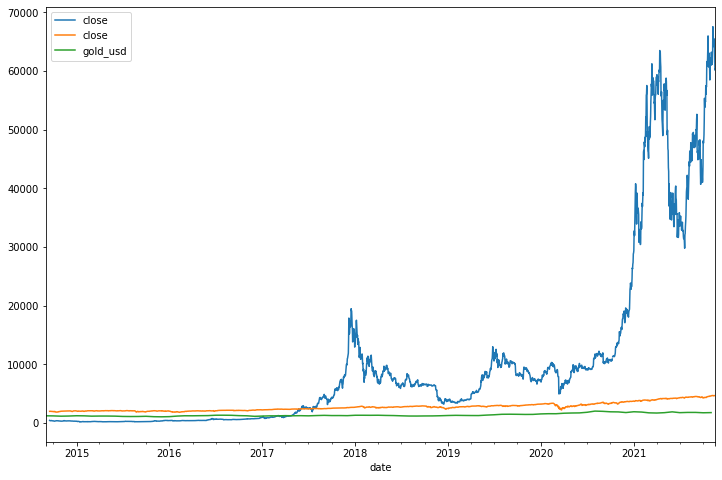

In [5]:
# Firts, plot the prices of bitcoin, S&P 500 and Gold
fig, ax = plt.subplots(figsize=(12, 8))
bitcoin.plot(x="date", y="close", ax=ax)
sp500.plot(x="date", y="close", ax=ax)
monthly_data.plot(x="date", y="gold_usd", ax=ax)


From the graph above we can see that since 2017 BTC has not stopped growing, with a lot of volatility on the way, but at the end of the day it gave incredible returns.

In addition, to correctly compare the returns, we will have to transfer all of them to the monthly returns, since we do not have daily returns for gold.

In [6]:
# Set data as index for all the dataframes
bitcoin.set_index("date", inplace=True)
sp500.set_index("date", inplace=True)
monthly_data.set_index("date", inplace=True)
# inner join monthly_data with bitcoin and sp500
merged = monthly_data.merge(bitcoin, how="inner", left_index=True, right_index=True)
merged = merged.merge(sp500, how="inner", left_index=True, right_index=True)
# change close_x to bitcoin and close_y to sp500
merged.rename(columns={"close_x": "bitcoin", "close_y": "sp500"}, inplace=True)
# left only gold_usd, bitcoin and sp500
merged = merged[["gold_usd", "bitcoin", "sp500"]]
merged.head()


,gold_usd,bitcoin,sp500
date,,,
2014-10-01,1223.565,383.614990,1946.160034
2014-12-01,1200.440,379.244995,2053.439941
2015-04-01,1198.253,247.272003,2059.689941
2015-05-01,1197.684,232.078995,2108.290039
2015-06-01,1182.248,222.925995,2111.729980


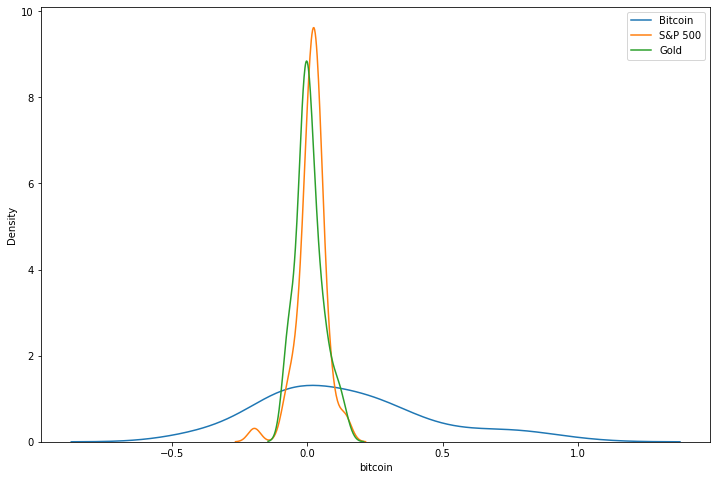

In [7]:
# Plot displot of the returns of each asset
fig, ax = plt.subplots(figsize=(12, 8))
# return of the assest
bitcoin_returns = merged["bitcoin"].pct_change()
sp500_returns = merged["sp500"].pct_change()
gold_returns = merged["gold_usd"].pct_change()
# Plot the distribution of the returns
sns.kdeplot(bitcoin_returns, ax=ax)
sns.kdeplot(sp500_returns, ax=ax)
sns.kdeplot(gold_returns, ax=ax)
# add legends
ax.legend(["Bitcoin", "S&P 500", "Gold"])


In [8]:
# Describe the returns
describe = pd.concat(
    [bitcoin_returns.describe(), sp500_returns.describe(), gold_returns.describe()],
    axis=1,
)
describe.columns = ["Bitcoin", "S&P 500", "Gold"]
describe


,Bitcoin,S&P 500,Gold
count,55.000000,55.000000,55.000000
mean,0.136622,0.017176,0.008100
std,0.310130,0.051915,0.050164
min,-0.453110,-0.194466,-0.076747
25%,-0.073148,-0.001588,-0.016520
50%,0.106549,0.022649,-0.001561
75%,0.290883,0.040945,0.028101
max,0.958861,0.145804,0.141386


### Conclusions:
From the table above we can see:
- Bitcoin has the largest mean and median by far.
- Bitcoin has the highest standard development, being 6 times the standard of the other two assets.
- Bitcoin has the fat tails on both sides (minimum = -0.453, maximum = 0.959)
- Surprisingly, at least for monthly returns, bitcoin has a positive bias, while it is common for stocks to have a negative bias.

# 2.1 Analyze Bitcoin Returns.

## 2.1.1 Returns: ACF and PACF Analysis

The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number of periods or units. A lag corresponds to a certain point in time after which we observe the first value in the time series.

The correlation coefficient can range from -1 (a perfect negative relationship) to +1 (a perfect positive relationship). A coefficient of 0 means that there is no relationship between the variables. Also, most often, it is measured either by Pearson’s correlation coefficient or by Spearman’s rank correlation coefficient.

It’s most often used to analyze sequences of numbers from random processes, such as economic or scientific measurements. It can also be used to detect systematic patterns in correlated data sets such as securities prices or climate measurements. 

To summarize, autocorrelation is the correlation between a time series (signal) and a delayed version of itself, while the ACF plots the correlation coefficient against the lag, and it’s a visual representation of autocorrelation.

Partial autocorrelation is a statistical measure that captures the correlation between two variables after controlling for the effects of other variables. For example, if we’re regressing a signal S at lag t $(S_{t})$ with the same signal at lags t-1, t-2 and t-3 $(S_{t-1}, S_{t-2}, S_{t-3})$, the partial correlation between $S_{t}$ and $S_{t-3}$ is the amount of correlation between $S_{t}$ and $S_{t-3}$ that isn’t explained by their mutual correlations with $S_{t-1}$ and $S_{t-2}$.

That being said, the way of finding PACF between $S_{t}$ and $S_{t-3}$ is to use regression model




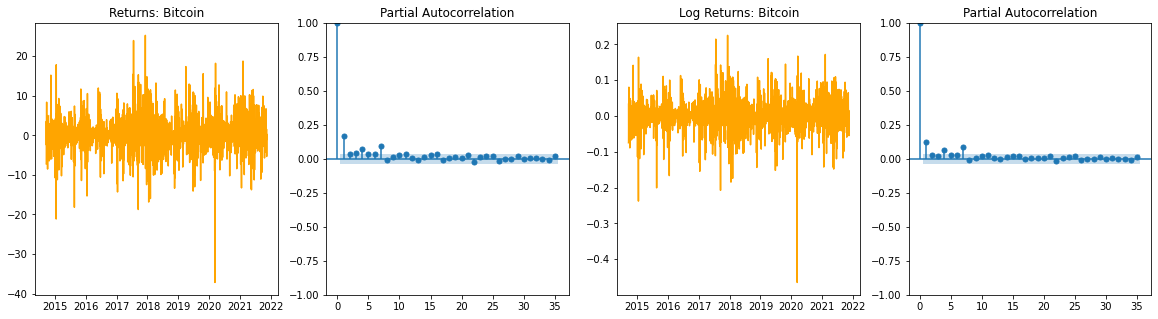

In [9]:
bitcoin.name = "Bitcoin"

fig, axes = plt.subplots(1, ncols=4, figsize=(20, 5))

# Returns
returns = 100 * bitcoin.close.pct_change().dropna()
axes[0].plot(returns, color="orange")
axes[0].set_title(f"Returns: {bitcoin.name}")

plot_pacf(returns ** 2, ax=axes[1], method="ywm")

# Log Returns
# we assume that prices are distributed log normally
# (which, in practice, may or may not be true for any given price series)
log_returns = np.log(bitcoin.close / bitcoin.close.shift(1)).dropna()
axes[2].plot(log_returns, color="orange")
axes[2].set_title(f"Log Returns: {bitcoin.name}")

plot_pacf(log_returns ** 2, ax=axes[3], method="ywm")

plt.show()


We can see that the level of ACF and PCAF drops dramatically after the first lag. That is a sign that we are probably facing a Random Walk.

## 2.1.2 Returns: Are normally distributed?

It is common in finance to use logarithmic returns because it has several benefits, both theoretical and algorithmic.

Text(0.5, 1.0, 'Log Returns')

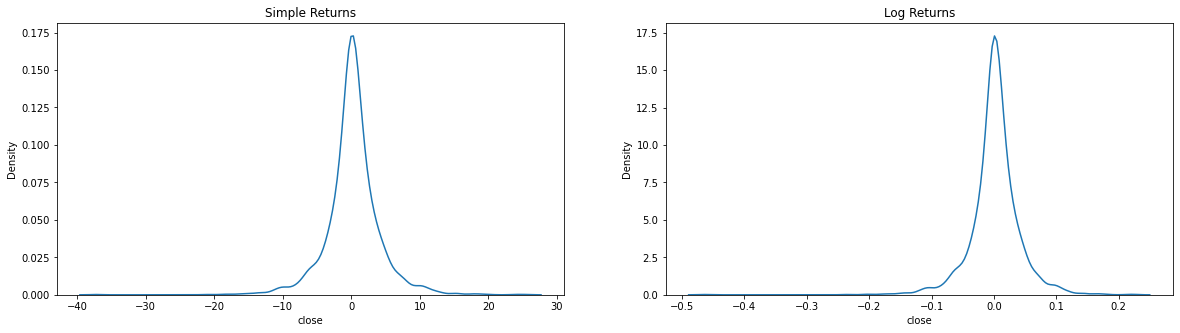

In [10]:
%matplotlib inline
returns = 100 * bitcoin.close.pct_change().dropna()
log_returns = np.log(bitcoin.close/bitcoin.close.shift(1)).dropna()
from scipy import stats
# Plot distribution plots of simple returns and log returns
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.kdeplot(returns, ax=ax1)
ax1.set_title('Simple Returns')
sns.kdeplot(log_returns, ax=ax2)
ax2.set_title('Log Returns')

At first glance, both simple and logarithmic returns have fat tails, negative bias, and high kurtosis.

In [11]:
# Calculate Kurtosis and Skewness
kurtosis = stats.kurtosis(log_returns)
skewness = stats.skew(log_returns)
print(f"Kurtosis: {kurtosis}")
print(f"Skewness: {skewness}")


Kurtosis: 11.322346646642968
Skewness: -0.8066920976134418


A standard normal distribution has a kurtosis of 3 and a skewness of 0. The level of skewness is not that great, absolute values ​​below 1 are considered moderate. On the other hand, the kurtosis is high if we compare it with a normal distribution.

## 2.1.3 Returns: Is our data Stationary?

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [12]:
from statsmodels.tsa.stattools import adfuller

adfuller_results = adfuller(log_returns)

print(f"ADF Statistic: {adfuller_results[0]}")
print(f"p-value: {adfuller_results[1]}")
print("Critical Values:")
for key, value in adfuller_results[4].items():
    print(f"{key}: {value:.4f}")


ADF Statistic: -15.370808803276837
p-value: 3.5105676195070238e-28
Critical Values:
1%: -3.4329
5%: -2.8627
10%: -2.5674


P-value is by far less than 0.05 so we can reject the null hypothesis so the data does not have unit root and it is stationary

## 2.2 Bitcoin Volatility Profile

## 2.2.1 Heteroskedasticity
Heteroskedasticity describes the irregular pattern of variation of an error term, or variable, in a statistical model. Essentially, where there is heteroskedasticity, observations do not conform to a linear pattern. Instead, they tend to cluster.

We will use White's test to determine if heteroscedasticity is present in our data 

<AxesSubplot:xlabel='period', ylabel='close'>

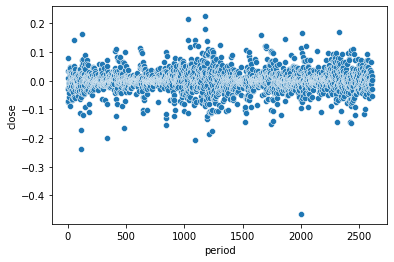

In [13]:
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm

log_returns = np.log(bitcoin.close / bitcoin.close.shift(1)).dropna()

data = log_returns.reset_index()
# Add period column that increase by 1
data["period"] = data.index
# Define response variable
y = data["close"]

# Define predictor variables
x = data["period"]

# Add constant to predictor variables
x = sm.add_constant(x)

# Fit regression model
model = sm.OLS(y, x.astype(float)).fit()

sns.scatterplot(x="period", y="close", data=data)


In [14]:
# Perform White's test
white_test = het_white(model.resid, model.model.exog)

# Define labels to use for output of White's test
labels = ["Test Statistic", "Test Statistic p-value", "F-Statistic", "F-Test p-value"]

# Print results of White's test
print(dict(zip(labels, white_test)))


{'Test Statistic': 3.1370513483195723, 'Test Statistic p-value': 0.20835213496378116, 'F-Statistic': 1.5686081050861354, 'F-Test p-value': 0.20853145084895824}


White’s test uses the following null and alternative hypotheses:

Null (H0): Homoscedasticity is present (residuals are equally scattered)

Alternative (HA): Heteroscedasticity is present (residuals are not equally scattered)

Since the p-value is not less than 0.05, we do not reject the null hypothesis.

This means that we do not have sufficient evidence to say that heteroscedasticity is present in the regression model.

An interesting thing to do is check the heteroscedasticity of the S&P500, which is well known for presenting clusters in its volatility.

<AxesSubplot:xlabel='period', ylabel='close'>

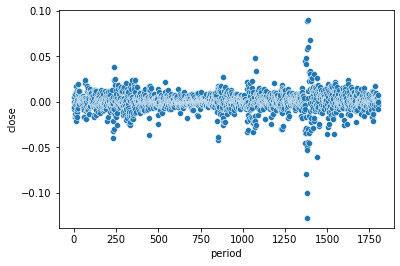

In [15]:
log_returns = np.log(sp500.close / sp500.close.shift(1)).dropna()

data = log_returns.reset_index()
# Add period column that increase by 1
data["period"] = data.index
# Define response variable
y = data["close"]

# Define predictor variables
x = data["period"]

# Add constant to predictor variables
x = sm.add_constant(x)

# Fit regression model
model = sm.OLS(y, x.astype(float)).fit()

sns.scatterplot(x="period", y="close", data=data)


In [16]:
# Perform White's test
white_test = het_white(model.resid, model.model.exog)

# Define labels to use for output of White's test
labels = ["Test Statistic", "Test Statistic p-value", "F-Statistic", "F-Test p-value"]

# Print results of White's test
print(dict(zip(labels, white_test)))


{'Test Statistic': 11.857328935612573, 'Test Statistic p-value': 0.00266203484901031, 'F-Statistic': 5.957965779687359, 'F-Test p-value': 0.002636395899518943}


Results interesting that for the S&P 500 we can reject the null hypothesis but for the BTC we can't. It seems that for BTC all the high volatility is present almost all the time in a constant way.

## 2.2.2 GARCH Model Analysis

Even though we fail to reject homoscedasticity in our BTC returns, it is widely known in the financial world that volatility in assets is clustered, whereby periods of high volatility are followed by periods of high volatility and periods of low volatility are followed by periods of low volatility. With that said, we will model the volatility of BTC with a model that captures this characteristic.

The generalized autoregressive conditional heteroskedasticity (GARCH) process is an econometric term developed in 1982 by Robert F. Engle, an economist and 2003 winner of the Nobel Memorial Prize for Economics. GARCH describes an approach to estimate volatility in financial markets.

The general process for a GARCH model involves three steps. The first is to estimate a best-fitting autoregressive model. The second is to compute autocorrelations of the error term. The third step is to test for significance.

Two other widely used approaches to estimating and predicting financial volatility are the classic historical volatility (VolSD) method and the exponentially weighted moving average volatility (VolEWMA) method.

### Asymmetry in Financial Shocks
    
There is some asymmetry in financial shocks, higher volatilities are often associated with negative returns. There are several models that capture this particularity, here we will focus on two: GJR GARCH and EGARCH.

GRJ GARCH : 

 $ GJR \ GARCH(1,1):\sigma_t^2 = (1-\alpha-\beta)\omega_0 + (\alpha + \gamma_{t-1}I_{t-1})\epsilon_{t-1}^2+\beta\sigma_{t-1}^2$
 
 where : 
 
 $ \omega_0 = long \ term \ variance $
 
 $ \alpha = immidiate \ impact \ of \ the \ shock \ factor $
 
 $ \beta = duration \ of \ the \ impact \ factor $

 $ \alpha + \beta < 1 \ the \ model \ is \ mean \ reverting \ to \ long \ term \ variance $

 $ \alpha \ and \ \beta \ are  \ positive \ parameters $



 
 $ if \ r_{t-1} < \mu  \ then \  I_{t-1} = 1 $
 
 $ if \ r_{t-1} > \mu  \ then  \ I_{t-1} = 0 $
 
EGARCH :

It's an Exponential GARCH. This models the logarithm of the variance. The model also accommodates asymmetry in that negative shocks can have a bigger impact on volatility than positive shocks. "

What model is better? :

One thing that could be done is to compare the AIC and BIC given by the models, knowing that lower values are preferred, that is one way to evaluate the trade-off between the goodness of fit and the complexity of the model.

In [17]:
# Import the arch_model from arch library
from arch import arch_model

# Calulate de log returns for btc
log_returns_btc = 100 * np.log(bitcoin.close / bitcoin.close.shift(1)).dropna()
# Instantiate the arch model
# First we will try with EGARCH(1,1)
btc_eg = arch_model(
    log_returns_btc,
    p=1,
    q=1,
    o=1,  # We add the o = 1 parameter and change vol for 'EGARCH'
    mean="constant",
    vol="EGARCH",  # For EGARCH model
    dist="skewt",  # To consider the skewt distribution
)
# Fit the model
btc_eg_result = btc_eg.fit(update_freq=5, disp="off")
# Plot the results
print(btc_eg_result.aic)
print(btc_eg_result.bic)


13315.604786299084
13356.677206279977


In [18]:
# Now we will try with GRJGARCH(1,1)
btc_eg = arch_model(
    log_returns_btc,
    p=1,
    q=1,
    o=1,  # We add the o = 1 parameter and change vol for 'GRJGARCH'
    mean="constant",
    vol="GARCH",  # For GRJGARCH model
    dist="skewt",  # To consider the skewt distribution
)
# Fit the model
btc_eg_result = btc_eg.fit(update_freq=5, disp="off")
# Plot the results
print(btc_eg_result.aic)
print(btc_eg_result.bic)


13360.492202864758
13401.564622845652


The AIC and BIC for egarch and gjr_garch are roughtly the same. We are indifferent about which model to choose, that is why we opted for EGARCH.

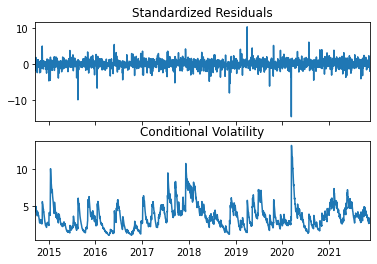

In [19]:
# Plot the results of the model
btc_eg = arch_model(
    log_returns_btc,
    p=1,
    q=1,
    o=1,  # We add the o = 1 parameter and change vol for 'EGARCH'
    mean="constant",
    vol="EGARCH",  # For EGARCH model
    dist="skewt",  # To consider the skewt distribution
)
btc_eg_result.plot()
plt.show()


In [20]:
# Calculate the residuals
resid_btc = btc_eg_result.resid / btc_eg_result.conditional_volatility
# Calculate the conditional volatility
vol_btc = btc_eg_result.conditional_volatility
# Create a DataFrame with the results
btc_eg = pd.DataFrame({"resid_btc": resid_btc, "vol_btc": vol_btc})
# we will add to our original bitcoin dataframe the new columns residuals and conditional_volatility
bitcoin = pd.merge(bitcoin, btc_eg, how="left", left_index=True, right_index=True)
bitcoin.dropna(inplace=True)
bitcoin.head()


,open,high,low,close,volume,resid_btc,vol_btc
date,,,,,,,
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,-1.775732,4.293823
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,-1.613835,4.585658
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,0.697014,4.807329
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,-0.562545,4.723376
2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,0.147524,4.551096


# 2.3 Can Bitcoin improve our Portfolio Performance?

Let's say we only have S&P 500 in our portfolio, now ... what if we want to add some BTC?
We first want to check how both assets covary with each other.

To achieve that we need to model the conditional volatility of the S&P500

In [21]:
# Calculate the log returns for sp500
log_returns_sp500 = 100 * np.log(sp500.close / sp500.close.shift(1)).dropna()
sp500_eg = arch_model(
    log_returns_sp500,
    p=1,
    q=1,
    o=1,  # We add the o = 1 parameter and change vol for 'EGARCH'
    mean="constant",
    vol="EGARCH",  # for EGARCH model
    dist="skewt",  # To consider the skewt distribution
)
# Train the model
sp500_eg_result = sp500_eg.fit(update_freq=5, disp="off")
# Calculate the residuals
resid_sp500 = sp500_eg_result.resid / sp500_eg_result.conditional_volatility
# Calculate the conditional volatility
vol_sp500 = sp500_eg_result.conditional_volatility
# Create a DataFrame with the results and the conditional volatility
sp500_eg = pd.DataFrame({"resid_sp500": resid_sp500, "vol_sp500": vol_sp500})
# Plot the results
sp500_eg_result


                           Constant Mean - EGARCH Model Results                          
Dep. Variable:                             close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -2067.43
Distribution:      Standardized Skew Student's t   AIC:                           4148.86
Method:                       Maximum Likelihood   BIC:                           4187.34
                                                   No. Observations:                 1804
Date:                           Sun, Jan 09 2022   Df Residuals:                     1803
Time:                                   22:08:17   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

<function matplotlib.pyplot.show(close=None, block=None)>

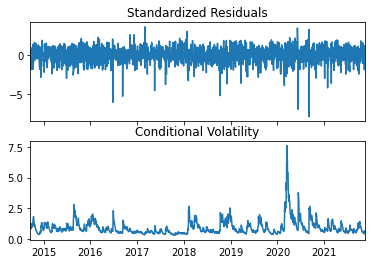

In [22]:
sp500_eg_result.plot()
plt.show


### Calculate the Covariance between BTC and S&P500

Once the dynamic volatility of the S&P500 has been calculated, we can now calculate the covariance between both assets. But before that, we will estimate the correlation of the two time series. It is important to note that, to do it the right way, we need to have the same timestamp for both assets ... this is not our case because we have a closing price for the S&P500, which is the time when that market closes. , but it does not need to coincide with the time of the BTC closing price, which is probably the time the day ends in a certain time zone. Also BTC trades 365 days a year, while the stock market only 252. For simplicity, we will avoid the timestamp problem and assume that the closing time coincides, and we will do an "inner" join to solve the "365 vs 252 days " problem.

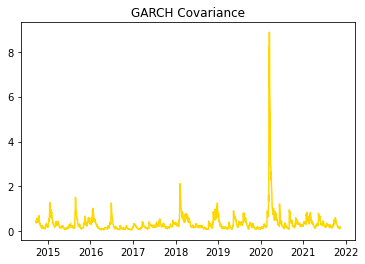

In [23]:
# We will add to our original sp500 dataframe the new columns residuals and conditional_volatility
sp500 = pd.merge(sp500, sp500_eg, how="left", left_index=True, right_index=True)
sp500.dropna(inplace=True)
# merge the results from the GARCH models into a single dataframe
merged = pd.merge(
    sp500[["resid_sp500", "vol_sp500"]],
    bitcoin[["resid_btc", "vol_btc"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# Calculate the correlation between the residuals of the SP500 and the Bitcoin
corr = np.corrcoef(merged.resid_sp500 * 100, merged.resid_btc * 100)[0, 1]
# Now calculate de covariance between the residuals of the SP500 and the Bitcoin
cov = corr * merged.vol_sp500 * merged.vol_btc
# Plot the GARCH Covariance between the residuals of the SP500 and the Bitcoin
plt.plot(cov, color="gold")
plt.title("GARCH Covariance")
plt.show()


### Covariance vs S&P500

we can appreciate several peaks in the dynamic covariance between S&P 500 and BTC, let's see where these peaks have occurred ...

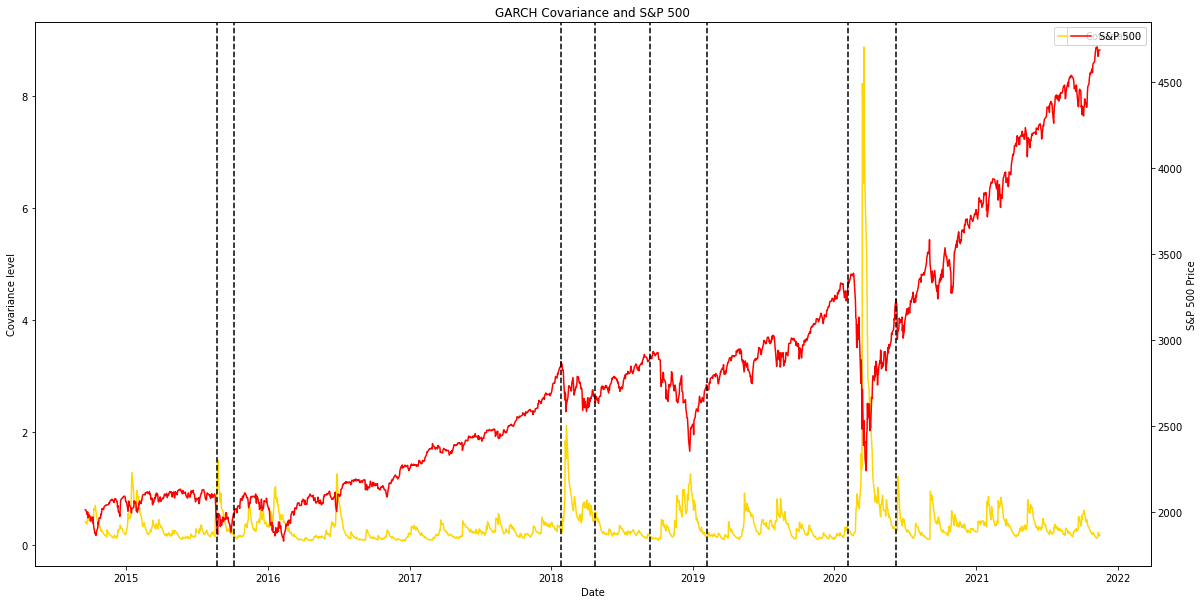

In [24]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(cov, label="Covariance", color="gold")
ax1.set_xlabel("Date")
ax1.set_ylabel("Covariance level")
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(sp500.close, label="S&P 500", color="red")
ax2.set_ylabel("S&P 500 Price")
ax2.legend()
plt.title("GARCH Covariance and S&P 500")
plt.axvline(x=sp500.index[-365], color="black", linestyle="--")
plt.axvline(x=sp500.index[-450], color="black", linestyle="--")
plt.axvline(x=sp500.index[-700], color="black", linestyle="--")
plt.axvline(x=sp500.index[-800], color="black", linestyle="--")
plt.axvline(x=sp500.index[-900], color="black", linestyle="--")
plt.axvline(x=sp500.index[-960], color="black", linestyle="--")
plt.axvline(x=sp500.index[-1540], color="black", linestyle="--")
plt.axvline(x=sp500.index[-1570], color="black", linestyle="--")
plt.show()


In the graph above, we can see that during periods of stress (high dips in the S&P500) the covariance increases dramatically, which is not a wishful scenario at that time, because you lose with both assets.

We can say that BTC is definitely not a hedge against drawdowns in the market.

What if we want to see the covariance distribution?...

<AxesSubplot:ylabel='Density'>

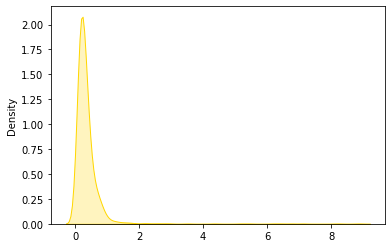

In [25]:
# Plot a kde of the covariance
sns.kdeplot(cov, shade=True, color="gold")


The covariance is heavily skewed to the right, which makes sense with the conclusion above.

### Does it help to include Bitcoin in my portfolio to decrease the variance?

To see that we will create two portfolios, one called portfolio_a with 0.9 in BTC and the rest in S&P500 and another with 0.5 BTC and 0.5 in S&P500, then we will compare the variance of both with the variance of the S&P500.

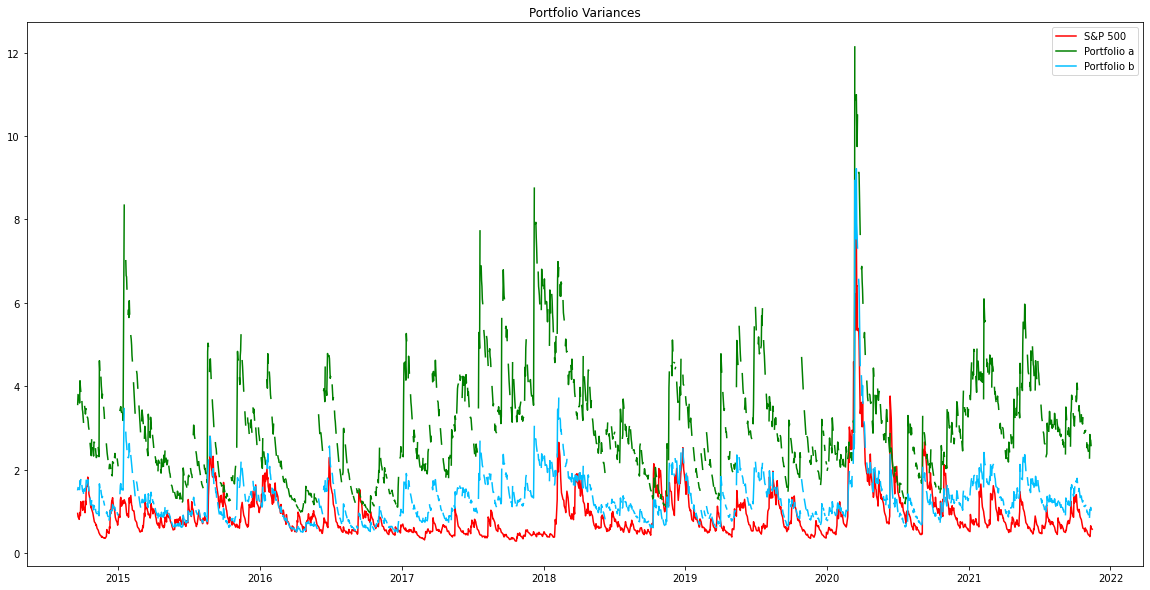

In [26]:
# Define weights
Wa1 = 0.9
Wa2 = 1 - Wa1
Wb1 = 0.5
Wb2 = 1 - Wb1

# Calculate portfolio variance
portvar_a = (
    Wa1 ** 2 * bitcoin.vol_btc + Wa2 ** 2 * sp500.vol_sp500 + 2 * Wa1 * Wa2 * cov
)
portvar_b = (
    Wb1 ** 2 * bitcoin.vol_btc + Wb2 ** 2 * sp500.vol_sp500 + 2 * Wb1 * Wb2 * cov
)

# Plot the data
fig, ax1 = plt.subplots(figsize=(20, 10))
plt.plot(sp500.vol_sp500, label="S&P 500", color="red")
plt.plot(portvar_a, color="green", label="Portfolio a")
plt.plot(portvar_b, color="deepskyblue", label="Portfolio b")
plt.legend(loc="upper right")
plt.title("Portfolio Variances")
plt.show()


It seems that adding BTC only increases the volatility of our portfolio, with the portfolio_a being the riskiest.

Another question we could ask ourselves is, How is the behavior of the Beta?

Remember that Beta is a coefficient that measure the volatility of an individual stock compared to the systematic risk of the entire market. 

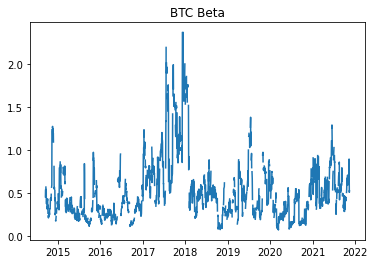

In [27]:
# Compute the Beta for BTC
stock_beta = corr * (bitcoin.vol_btc / sp500.vol_sp500)

# Plot the Beta
plt.title("BTC Beta")
plt.plot(stock_beta)
plt.show()


A beta that is greater than 1.0 indicates that the security's price is theoretically more volatile than the market. For example, if a stock's beta is 1.2, it is assumed to be 20% more volatile than the market.

In the period 2017-2018, the Beta was extremely high and reached values ​​above 2.

Anyway, it is not correct to calculate Beta using S&P 500 as market because the Cryptocurrency market is a different one.

### Risk vs Return - Portfolio of BTC and S&P500

But how does return to risk vary with different combinations of weights? To achieve that we will use the pypfopt library which has several tools to make portfolio optimization.

In [28]:
# First we need to merge both assets close prices
merged_outer = pd.merge(
    bitcoin.close, sp500.close, how="outer", left_index=True, right_index=True
)
# change name of close_x and close y with BTC and SP500
merged_outer.rename(columns={"close_x": "BTC", "close_y": "SP500"}, inplace=True)
# fill nan with the previous value
merged_outer.fillna(method="ffill", inplace=True)
merged_outer.head(5)


,BTC,SP500
date,,
2014-09-18,424.440002,2011.359985
2014-09-19,394.795990,2010.400024
2014-09-20,408.903992,2010.400024
2014-09-21,398.821014,2010.400024
2014-09-22,402.152008,1994.290039


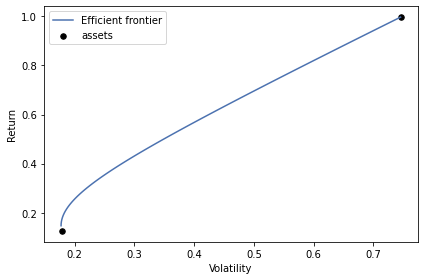

In [29]:
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(merged_outer, frequency=365)
S = risk_models.sample_cov(merged_outer, frequency=365)

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()


In the previous graph we can see that adding BTC to our portfolio does not reduce risk in any combination

# 2.4 Could BTC be used as a hedge against inflation?

The first we need to understand is the concept of hedge. In finance a hedge means strategically using financial instruments or market strategies to offset the risk of any adverse price movements, in our specific case, upward movements of the IPC.

The CPI values ​​that we have access to are in a monthly period, so we must adjust our BTC returns to monthly.

In [30]:
# We merge both datasets with inner join.
monthly_data = pd.merge(
    monthly_data, merged_outer, how="inner", left_index=True, right_index=True
)
monthly_data
# Add for each column in monthly_data a ret column with the return of the column
for i in monthly_data.columns.to_list():
    monthly_data[i + "_ret"] = monthly_data[i].pct_change()
monthly_data.dropna(inplace=True)


### BTC vs Inflation 

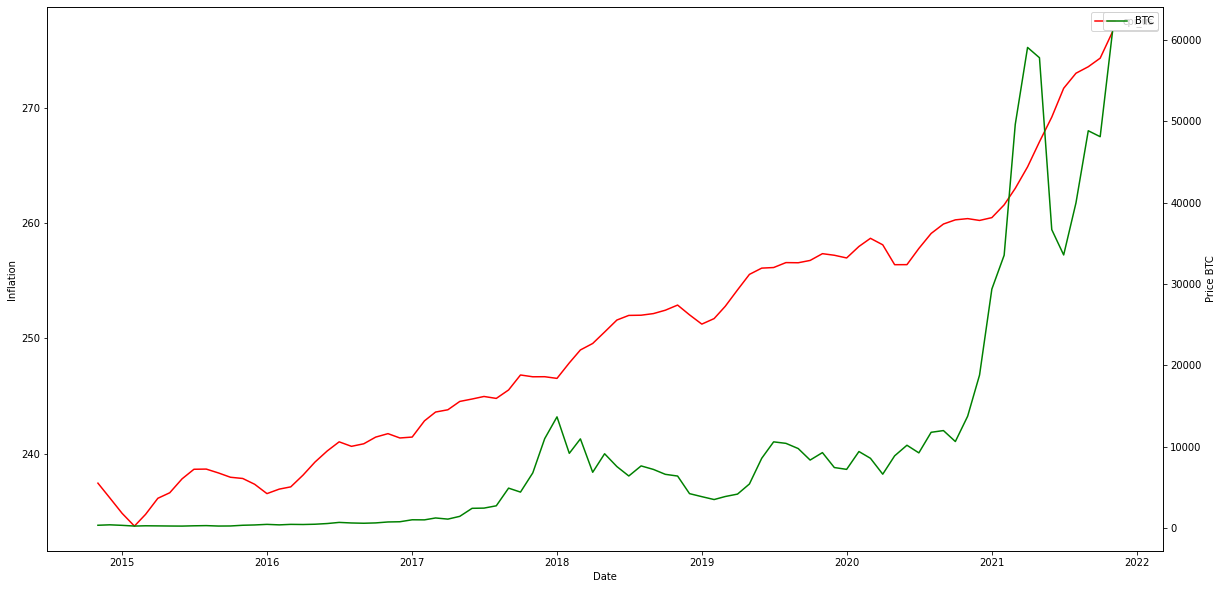

In [31]:
# Plot cpi_us and BTC in the same plot twin x axis
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(monthly_data.cpi_us, label="cpi_us", color="red")
ax1.set_xlabel("Date")
ax1.set_ylabel("Inflation")
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(monthly_data.BTC, label="BTC", color="green")
ax2.set_ylabel("Price BTC")
ax2.legend()
plt.show()


At first glance, it appears that the price of BTC grew as the CPI grew ... anyway, it is good practice to calculate the correlation with returns rather than prices or raw time series.

### Correlation of the returns

In [32]:
# Leave only the columns with the sufix _ret
monthly_data_ret = monthly_data.filter(regex="_ret")
monthly_data_ret.head()


,gold_usd_ret,cpi_us_ret,BTC_ret,SP500_ret
date,,,,
2014-11-01,-0.038537,-0.002512,-0.150844,0.036939
2014-12-01,0.020424,-0.005399,0.164225,0.017537
2015-01-01,0.040729,-0.005670,-0.171383,0.002659
2015-02-01,-0.014594,-0.004706,-0.277732,-0.031041
2015-03-01,-0.040991,0.004343,0.146406,0.054893


<AxesSubplot:>

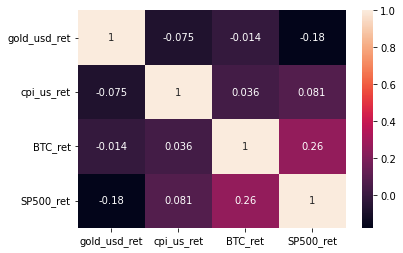

In [33]:
# plot a heat map correlation for all the columns in the dataframe
sns.heatmap(monthly_data_ret.corr(), annot=True)


Correlation between BTC and cpi is very low ... only 0.036

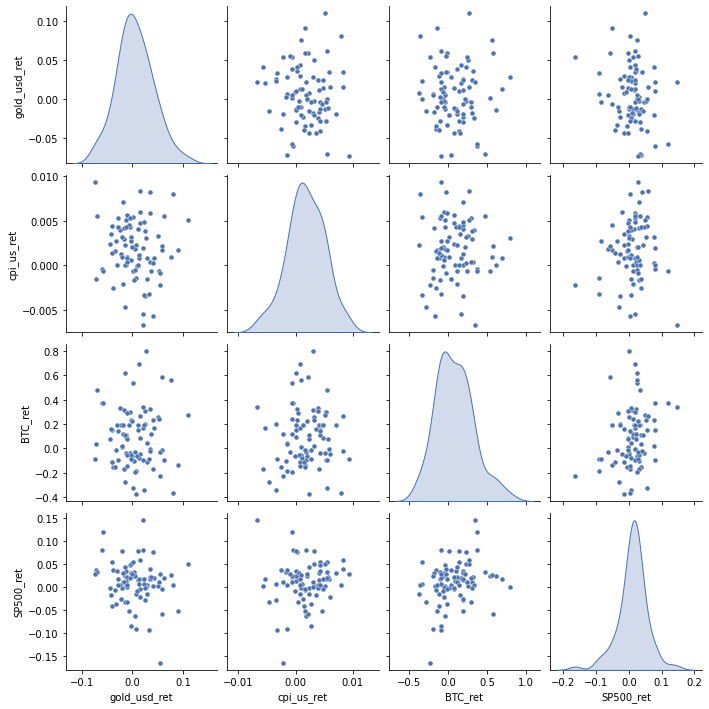

In [34]:
# plot a correlation plot between all the columns in the dataframe
sns.pairplot(
    monthly_data_ret,
    kind="scatter",
    diag_kind="kde",
    plot_kws={"s": 25},
    diag_kws={"shade": True},
)


From the heat map and scatter plot, we cannot see any clear correlation between BTC and CPI ...

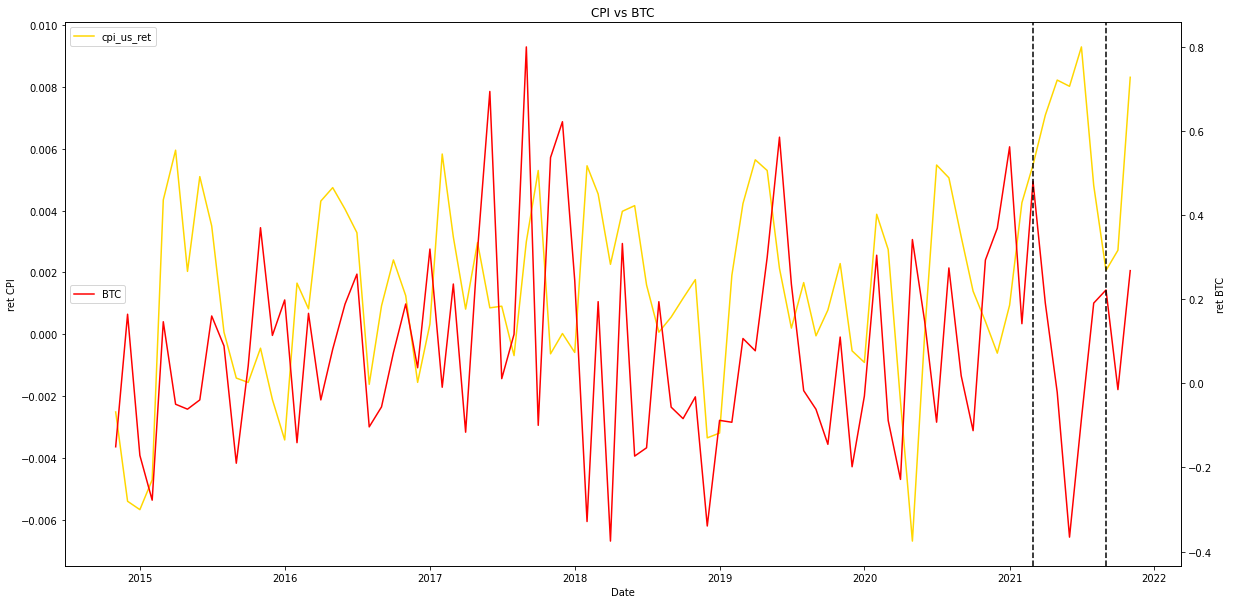

In [35]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(monthly_data_ret.cpi_us_ret, label="cpi_us_ret", color="gold")
ax1.set_xlabel("Date")
ax1.set_ylabel("ret CPI")
plt.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.plot(monthly_data_ret.BTC_ret, label="BTC", color="red")
ax2.set_ylabel("ret BTC")
plt.legend(loc="center left")
plt.title("CPI vs BTC")
plt.axvline(x=monthly_data_ret.index[-9], color="black", linestyle="--")
plt.axvline(x=monthly_data_ret.index[-3], color="black", linestyle="--")
plt.show()


Furthermore, we can see that in periods like 2021-2022 (high inflation in the US) BTC and inflation go their separate ways ... while inflation rose, BTC fell, which is not what we expect for an inflation hedge ...

We cannot tell from the data we have that BTC could be used as an inflation hedge...

# 4. Portfolio Optimization

There are some considerations that we must take into account before creating a portfolio with the four assets that we have (CPI, GOLD, BTC and S&P 500):

- In real life, one could trade gold futures or ETFs that replicate its price.
- Also, if you want to expose yourself to inflation, you'd better buy a TIP, which is a Treasury bond that adjusts for inflation.
- We will work with monthly returns

For the sake of simplicity and the competition, we will avoid the first two points and consider gold and IPC as assets.



In [36]:
# eliminate the columns with sufix "_ret" in the dataframe monthly_data
monthly_data.drop(
    columns=["gold_usd_ret", "cpi_us_ret", "SP500_ret", "BTC_ret"],
    inplace=True,
)
monthly_data.head()


,gold_usd,cpi_us,BTC,SP500
date,,,,
2014-11-01,1176.413,237.433,325.748993,2018.050049
2014-12-01,1200.440,236.151,379.244995,2053.439941
2015-01-01,1249.333,234.812,314.248993,2058.899902
2015-02-01,1231.100,233.707,226.972000,1994.989990
2015-03-01,1180.636,234.722,260.201996,2104.500000


### Efficient Frontier:

The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk.

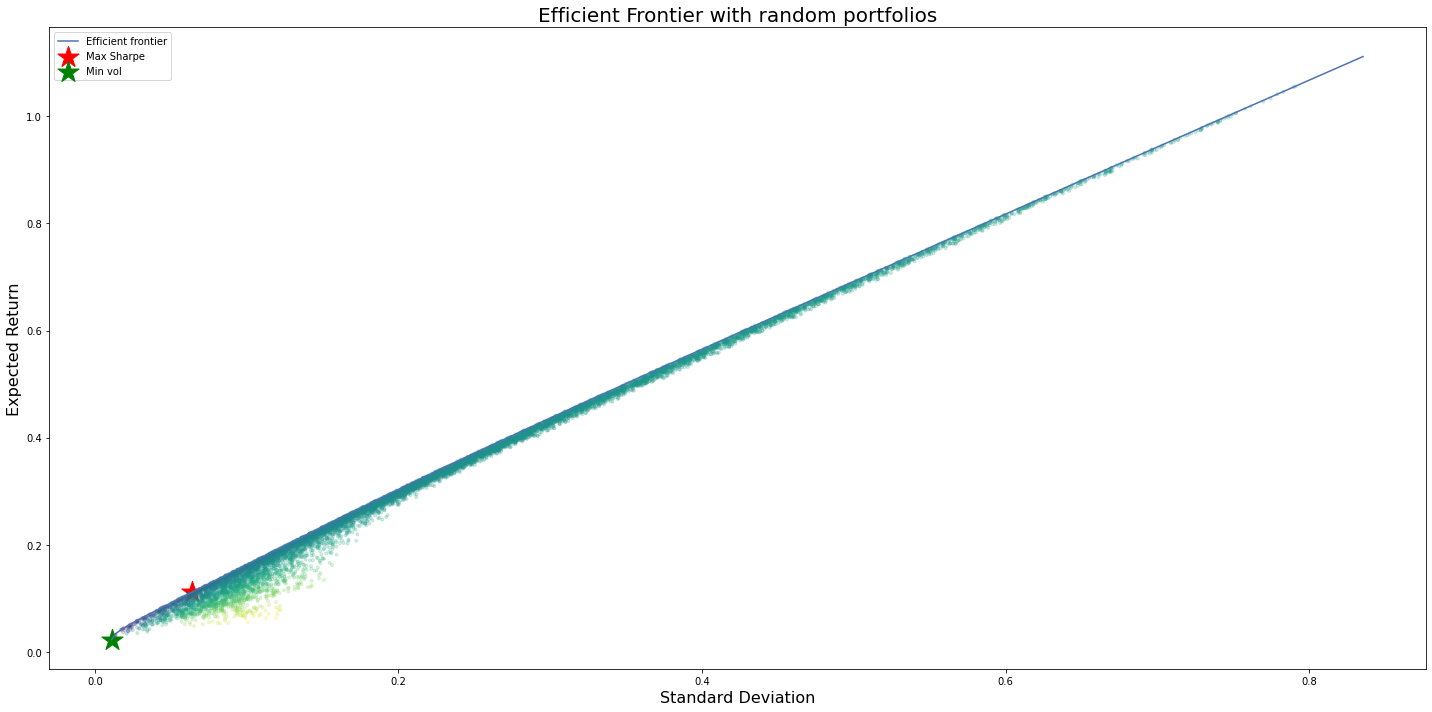

In [37]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(monthly_data, frequency=12)
S = risk_models.sample_cov(monthly_data, frequency=12)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(20, 10))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef = EfficientFrontier(
    mu, S
)  # we need to create a new instance of EfficientFrontier, if not we will get an error
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=500, c="r", label="Max Sharpe")

# Find the low vol portfolio
ef = EfficientFrontier(
    mu, S
)  # we need to create a new instance of EfficientFrontier, if not we will get an error
raw_weights_minvol = ef.min_volatility()
cleaned_weights_minvol = ef.clean_weights()
ret_min, std_min, _ = ef.portfolio_performance()
ax.scatter(std_min, ret_min, marker="*", s=500, c="g", label="Min vol")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r", alpha=0.2)

# Output
ax.set_title("Efficient Frontier with random portfolios", fontsize=20)
ax.legend()
plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.tight_layout()
plt.show()


## Which portfolio?

We will propose three portfolios based on different criteria:

- Maximum Sharpe Ratio
- Minimum Volatility
- Maximum Sortino Ratio

### Maximum Sharpe Ratio:

Maximum Sharpe Portfolio or Tangency Portfolio is a portfolio on the efficient frontier at the point where line drawn from the point (0, risk-free rate) is tangent to the efficient frontier.

We look to maximize the Sharpe ratio:

$ S = \frac{R-R_{f}}{\sigma}$



In [38]:
# Find the tangency portfolio
mu = expected_returns.mean_historical_return(monthly_data, frequency=12)
S = risk_models.sample_cov(monthly_data, frequency=12)
ef = EfficientFrontier(
    mu, S
)  # we need to create a new instance of EfficientFrontier, if not we will get an error
ef.max_sharpe()
ef.portfolio_performance(verbose=True)
print("Max Sharpe Portfolio:")
print(ef.clean_weights())


Expected annual return: 11.2%
Annual volatility: 6.4%
Sharpe Ratio: 1.43
Max Sharpe Portfolio:
OrderedDict([('gold_usd', 0.16168), ('cpi_us', 0.65289), ('BTC', 0.06502), ('SP500', 0.1204)])


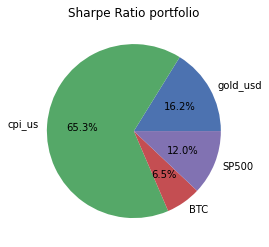

In [39]:
keys = ef.clean_weights().keys()
values = ef.clean_weights().values()
# create a dataframe with keys as columns and values as values of each column
df = pd.DataFrame(
    values, index=keys, columns=["weights"]
)  # Plot a pie chart with the weights of the portfolio
plt.pie(df.weights, labels=df.index, autopct="%1.1f%%")
plt.title("Sharpe Ratio portfolio")
plt.show()


### Minimun Variance Portfolio

A minimum variance portfolio is a collection of securities that combine to minimize the price volatility of the overall portfolio.

In [40]:
# Find the minimum volatility portfolio
mu = expected_returns.mean_historical_return(monthly_data, frequency=12)
S = risk_models.sample_cov(monthly_data, frequency=12)
ef = EfficientFrontier(
    mu, S
)  # we need to create a new instance of EfficientFrontier, if not we will get an error
ef.min_volatility()
ef.portfolio_performance(verbose=True)
print(ef.clean_weights())


Expected annual return: 2.3%
Annual volatility: 1.1%
Sharpe Ratio: 0.25
OrderedDict([('gold_usd', 0.01635), ('cpi_us', 0.98286), ('BTC', 0.0), ('SP500', 0.00079)])


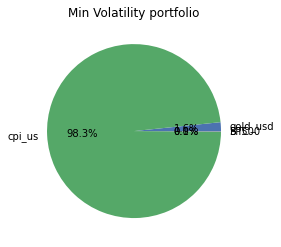

In [41]:
keys = ef.clean_weights().keys()
values = ef.clean_weights().values()
# create a dataframe with keys as columns and values as values of each column
df = pd.DataFrame(
    values, index=keys, columns=["weights"]
)  # Plot a pie chart with the weights of the portfolio
plt.pie(df.weights, labels=df.index, autopct="%1.1f%%")
plt.title("Min Volatility portfolio")
plt.show()


### Maximum Sortino Ratio Portfolio

The Sortino ratio is a variation of the Sharpe ratio that differentiates harmful volatility from total overall volatility by using the asset's standard deviation of negative portfolio returns—downside deviation—instead of the total standard deviation of portfolio returns. The Sortino ratio takes an asset or portfolio's return and subtracts the risk-free rate, and then divides that amount by the asset's downside deviation. The ratio was named after Frank A. Sortino.

$ S = \frac{R-R_{f}}{\sigma_d}$

Where the difference here is that ${\sigma_d}$ is the downside std dev.


In [42]:
from pypfopt import expected_returns, EfficientSemivariance

mu = expected_returns.mean_historical_return(monthly_data, frequency=12)
historical_returns = expected_returns.returns_from_prices(monthly_data)

es = EfficientSemivariance(mu, historical_returns)
es.efficient_return(0.20)

weights = es.clean_weights()
print(weights)
es.portfolio_performance(verbose=True)
print(es.clean_weights())


OrderedDict([('gold_usd', 0.37331), ('cpi_us', 0.37372), ('BTC', 0.13902), ('SP500', 0.11396)])
Expected annual return: 20.0%
Annual semi-deviation: 23.1%
Sortino Ratio: 0.78
OrderedDict([('gold_usd', 0.37331), ('cpi_us', 0.37372), ('BTC', 0.13902), ('SP500', 0.11396)])


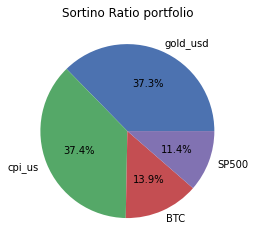

In [43]:
keys = es.clean_weights().keys()
values = es.clean_weights().values()
# create a dataframe with keys as columns and values as values of each column
df = pd.DataFrame(
    values, index=keys, columns=["weights"]
)  # Plot a pie chart with the weights of the portfolio
plt.pie(df.weights, labels=df.index, autopct="%1.1f%%")
plt.title("Sortino Ratio portfolio")
plt.show()


# 4. Final conclusions:

We reached the end of this document, our pipeline was:

1. Compare the BTC with the other assets.
2. Analyze returns and volatility of BTC.
3. Analyze the dynamic covariance between BTC and the market.
4. Analyze BTC as an inflation hedge.
5. Obtain an optimized portfolio with the available assets.

From point 1 we can say:

- Although BTC has outperformed all other assets, it has a lot of volatility (6 times the volatility of the S&P500).
- The positive bias, although in monthly returns, is something particular, stocks tend to have a negative bias that is less desirable.

From point 2:

- Returns present a behavior that does not depend on the trajectory.
- The skewness in daily returns is negative, which makes more sense with other financial assets.
- Surprisingly, we could not reject the null hypothesis of homoscedasticity for BTC.
- BTC exhibits high volatility during periods of crisis as other financial assets.

From point 3:

- BTC and the S&P500 have a very high positive covariance during drawdowns. This is not a desirable behavior as you lost with both assets.

From point 4:

- With the data available for this competition we could not find any sign of possible correlation between BTC and inflation.
- Also during 2021, when inflation increased in an incredible way, BTC has a lot of difficulties, with BTC being at least during the last year a bad idea as a hedge.

From point 5:

- BTC has so much variance with respect to the other assets that it distorts the efficient frontier graph makes it very wide.
- For all three criteria, the asset cpi was preferred.
- In the portfolio with minimal variance, almost the entire portfolio was for the cpi. However, in practice some limitations are imposed on the weights to avoid corner solutions.
- An interesting thing is that in the sortino ratio portfolio, BTC had more weight than in the sharpe ratio portfolio. This makes sense since the sortino ratio only penalizes negative volatility.
